In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from flows import *
from utl import *
from load_data import *
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Hypter parameters
K = 6  # length of the flow
learning_rate = 1e-3
iterrations = 1e5

In [3]:
DTYPE=tf.float32
NP_DTYPE=np.float32
num_bijectors = 4
n_epochs = 1000
lr = 1e-3

In [4]:
# constants
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

(-2.0, 2.0)

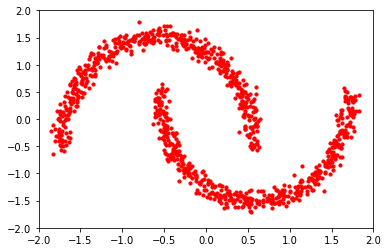

In [5]:
X_data = load_moon_dataset()
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X_data[:, 0], X_data[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [6]:
n_dims = X_data.shape[1]

## Construct Flow

### Step 1. Define Invertible leaky rectified linear transformation

In [7]:
class PReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="p_relu"):
        super(PReLU, self).__init__(
            forward_min_event_ndims=0,
            validate_args=validate_args,
            name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return log_abs_det_J_inv

### Step 2. Define MLP Normalizing Flow

In [10]:
# base distribution
# base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32), scale_diag=tf.ones([2], tf.float32))
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

d, r = 2, 2
bijectors = []

for i in range(K):
    scale = tf.compat.v1.get_variable('V', [d, r], dtype=tf.float32)  # factor loading
    shift = tf.compat.v1.get_variable('shift', [d], dtype=tf.float32)  # affine shift
    scale_tril = tf.compat.v1.get_variable('L', [int(d * (d + 1) / 2)], dtype=tf.float32)  # lower triangular

    bijector = tfb.Affine(
        scale_tril=tfp.math.fill_triangular(scale_tril),
        scale_perturb_factor=scale,
        shift=shift)
    bijectors.append(bijector)

    alpha = tf.abs(tf.compat.v1.get_variable('alpha', [], dtype=DTYPE)) + .01
    bijectors.append(PReLU(alpha=alpha))

mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])), name='mlp_bijector')
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)

Instructions for updating:
`Affine` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Matvec*)` where `tfb.Matvec*` is one of `MatvecDiag`, `MatvecTriL`, or `MatvecLinearOperator`.
Instructions for updating:
Do not call `graph_parents`.


In [11]:
names, samples = make_samples(base_dist, dist)

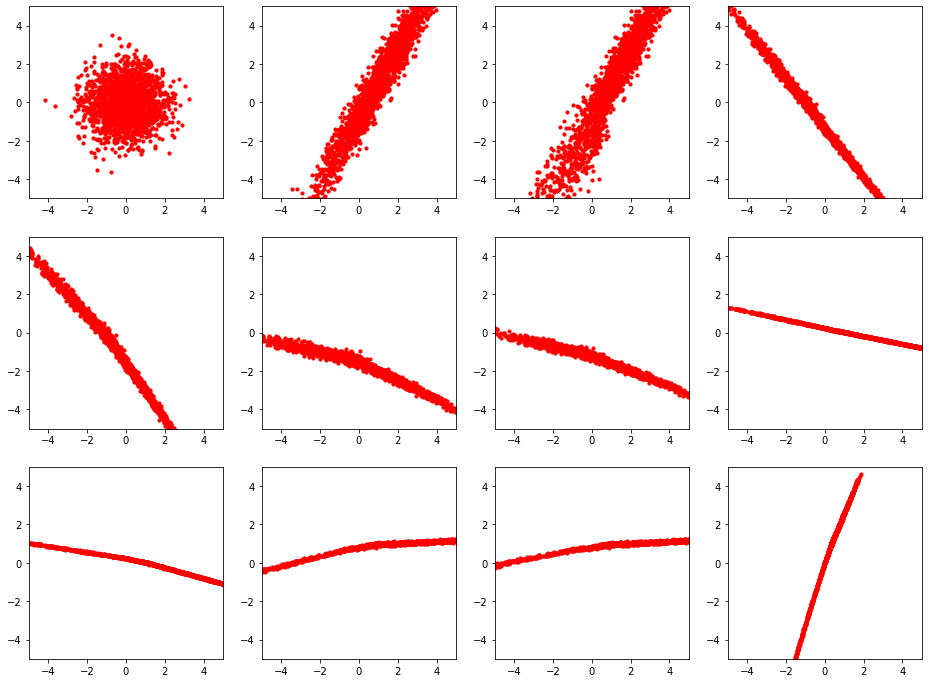

In [12]:
plot_samples(samples, names, rows=3)

In [14]:
history = train_dist_routine(X_data, dist, n_epochs=n_epochs, n_disp=int(n_epochs/50))

ValueError: Fill dimensions must be >= 0 for '{{node ones}} = Fill[T=DT_FLOAT, index_type=DT_INT32](tf.concat/concat, ones/Const)' with input shapes: [2], [] and with input tensors computed as partial shapes: input[0] = [2,?].